In [1]:
import os
import warnings
import math
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from sklearn.metrics import mean_squared_error, mean_absolute_error
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score,roc_curve,auc, f1_score, roc_auc_score,confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, normalize
from scipy import ndimage
import seaborn as sns

Using TensorFlow backend.


In [2]:
test_data = pd.read_csv('./datasets/exoTest.csv').fillna(0)
train_data = pd.read_csv('./datasets/exoTrain.csv').fillna(0)
train_data.head(5)

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [3]:
train_data['LABEL'].value_counts()

1    5050
2      37
Name: LABEL, dtype: int64

In [4]:
test_data.shape

(570, 3198)

In [5]:
categ = {2:1,   #change from 2 to 1: Represents presence of Exoplanet
         1:0,    #change from 1 to 0: No presence of Exoplanet
        }

In [6]:
train_data['LABEL']=[categ[item] for item in train_data['LABEL']]
test_data['LABEL'] = [categ[item] for item in test_data['LABEL']]

In [7]:
# Reference: https://towardsdatascience.com/exoplanet-hunting-using-machine-learning-d615958e1787

def reduce_memory(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe before optimization: {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe after optimization : {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
test_data = reduce_memory(test_data)
train_data = reduce_memory(train_data)

Memory usage of dataframe before optimization: 13.91 MB
Memory usage of dataframe after optimization : 6.25 MB
Decreased by 55.1%
Memory usage of dataframe before optimization: 124.12 MB
Memory usage of dataframe after optimization : 62.04 MB
Decreased by 50.0%


## Visualization

In [9]:
train_data.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,93.849998,83.809998,20.100000,-26.980000,-39.560001,-124.709999,-135.179993,-96.269997,-79.889999,...,-78.070000,-102.150002,-102.150002,25.129999,48.570000,92.540001,39.320000,61.419998,5.080000,-39.540001
1,1,-38.880001,-33.830002,-58.540001,-40.090000,-79.309998,-72.809998,-86.550003,-85.330002,-83.970001,...,-3.280000,-32.209999,-32.209999,-24.889999,-4.860000,0.760000,-11.700000,6.460000,16.000000,19.930000
2,1,532.640015,535.919983,513.729980,496.920013,456.450012,466.000000,464.500000,486.390015,436.559998,...,-71.690002,13.310000,13.310000,-29.889999,-20.879999,5.060000,-11.800000,-28.910000,-70.019997,-96.669998
3,1,326.519989,347.390015,302.350006,298.130005,317.739990,312.700012,322.329987,311.309998,312.420013,...,5.710000,-3.730000,-3.730000,30.049999,20.030001,-12.670000,-8.770000,-17.309999,-17.350000,13.980000
4,1,-1107.209961,-1112.589966,-1118.949951,-1095.099976,-1057.550049,-1034.479980,-998.340027,-1022.710022,-989.570007,...,-594.369995,-401.660004,-401.660004,-357.239990,-443.760010,-438.540009,-399.709991,-384.649994,-411.790009,-510.540009


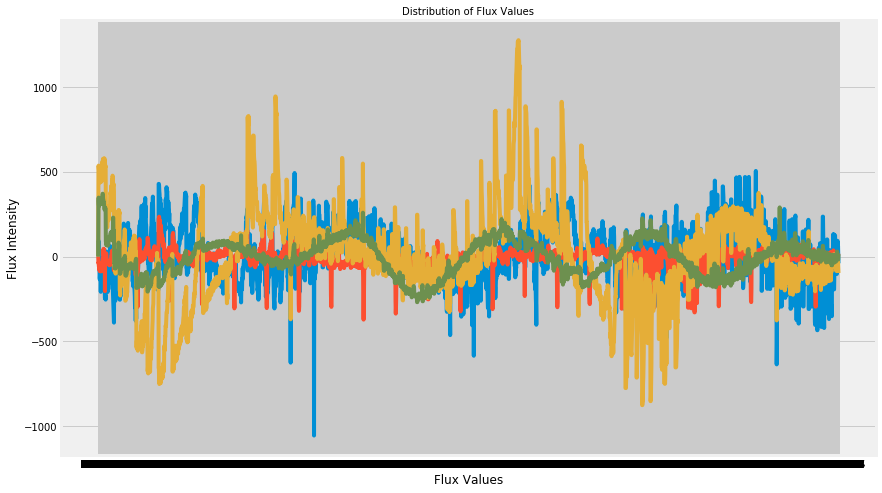

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 8
plt.title('Distribution of Flux Values', fontsize=10)
plt.xlabel('Flux Values')
plt.ylabel('Flux Intensity')
plt.plot(train_data.iloc[0,])
plt.plot(train_data.iloc[1,])
plt.plot(train_data.iloc[2,])
plt.plot(train_data.iloc[3,])
plt.show()

## Splitting the data

In [11]:
x_train = train_data.drop(["LABEL"], axis=1)
y_train = train_data["LABEL"]
x_test = test_data.drop(['LABEL'], axis=1)
y_test = test_data["LABEL"]

## Normalizing the data

In [12]:
x_train =  normalized = normalize(x_train)
x_test = normalize(x_test)

## Applying of gaussian filter

In [13]:
x_train = filtered = ndimage.filters.gaussian_filter(x_train, sigma=10)
x_test = ndimage.filters.gaussian_filter(x_test, sigma=10)

## Feature Scaling

In [14]:
std_scaler = StandardScaler()
x_train = scaled = std_scaler.fit_transform(x_train)
x_test = std_scaler.fit_transform(x_test)

## Dimensionality Reduction

In [15]:
from sklearn.decomposition import PCA
pca = PCA()
X_train = pca.fit_transform(x_train)
X_test = pca.transform(x_test)
total = sum(pca.explained_variance_)
k=0
current_variance=0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k=k+1

In [16]:
k #Value will give us total number of features w/ 90% explained variance

37

In [17]:
#Before PCA
x_test.shape

(570, 3197)

In [18]:
## Apply PCA w n_components = k (37)

In [19]:
pca = PCA(n_components = k)

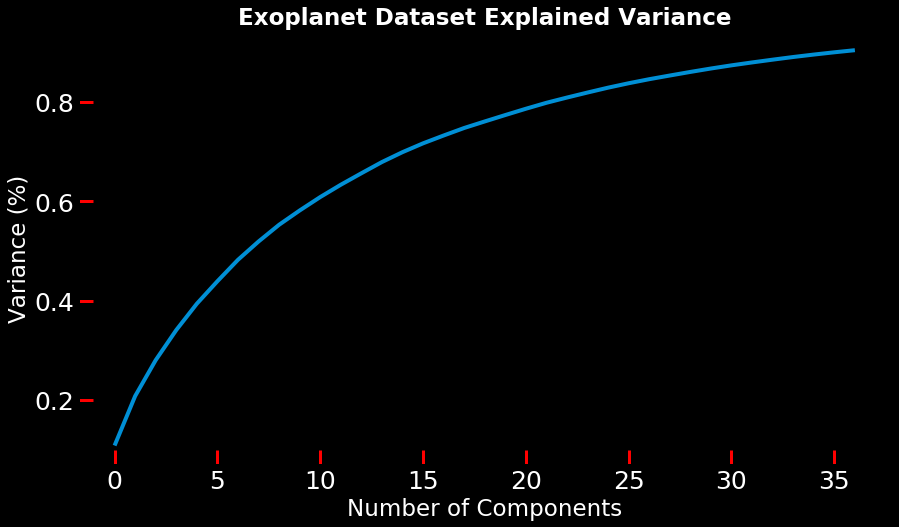

In [20]:
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
w = 'white'
b = 'black'

plt.rc_context({'axes.edgecolor':b,
                'xtick.color':w,
                'ytick.color':w,
                'figure.facecolor':b,
                'xtick.labelsize': 25,
                'ytick.labelsize': 25,
                'text.color': w,
                'axes.labelcolor':w}
                )


#plt.set_facecolor((1.0, 0.47, 0.42)
plt.figure()

ax = plt.axes()
# Setting the background color
ax.set_facecolor(b)
plt.grid(b=None)

plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.tick_params(direction='in', axis='both',color='red', width=3, length=15, grid_linewidth=4)


plt.xlabel('Number of Components', fontsize=23)
plt.ylabel('Variance (%)',  fontsize=23) #for each component
plt.title("Exoplanet Dataset Explained Variance", c=w, fontsize=23, fontweight='bold')
plt.show;

In [21]:
x_test.shape

(570, 37)

In [22]:
#Resampling as the data is highly unbalanced
print("Before Oversampling, count of label '1': {}".format(sum(y_train==1)))
print("Before Oversampling, count of label '0': {}".format(sum(y_train==0)))


Before Oversampling, count of label '1': 37
Before Oversampling, count of label '0': 5050


In [23]:
sm = SMOTE(random_state=27, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train.ravel())

In [24]:
y_train.shape

(5087,)

# Model Buliding

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (precision_score,
                            recall_score,
                            roc_curve, auc, 
                            f1_score, 
                            roc_auc_score, 
                            confusion_matrix, 
                            accuracy_score, 
                            classification_report)

In [26]:
def model(classifier, dtrain_x, dtrain_y, dtest_x, dtest_y):
        
        #https://python-forum.io/Thread-Colored-text-output-in-python-3
        black = lambda text: '\033[0;30m' + text + '\033[0m'
        red = lambda text: '\033[0;31m' + text + '\033[0m'
        green = lambda text: '\033[0;32m' + text + '\033[0m'
        yellow = lambda text: '\033[0;33m' + text + '\033[0m'
        blue = lambda text: '\033[0;34m' + text + '\033[0m'
        magenta = lambda text: '\033[0;35m' + text + '\033[0m'
        cyan = lambda text: '\033[0;36m' + text + '\033[0m'
        white = lambda text: '\033[0;37m' + text + '\033[0m'
        bold = lambda test: '\033[1m' + text + '\033[0m'
        underline = lambda test: '\033[4m' + text + '\033[0m]'
        
        txt_clr = red
        txt_clr1=bold


        #fit the model
        classifier.fit(dtrain_x, dtrain_y)
        predictions = classifier.predict(dtest_x)
        
        #Cross validation
        accuracies = cross_val_score(estimator = classifier, X = x_train_res, y = y_train_res, cv = 5, n_jobs = -1)
        mean = accuracies.mean()
        variance = accuracies.std()
        print("Accuracy mean----| "+ str(   round(mean,5)     ))
        print("Accuracy variance| "+ str(   round(variance,5)   ))
    
        #Accuracy
        accuracy_sc = accuracy_score(dtest_y,predictions)
        print ("\nAccuracy_score---| "+ str( round(accuracy_sc,5) ))
    
        #Classification report
        print ("\nclassification report |\n",(classification_report(dtest_y,predictions)))
    
        #Confusion matrix
        plt.figure(figsize=(12,10))
        plt.subplot(221)
        sns.heatmap(confusion_matrix(dtest_y,predictions),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
        plt.title("CONFUSION MATRIX",fontsize=20)

KNeighbors Classifier

Accuracy mean----| 0.99871
Accuracy variance| 0.00257

Accuracy_score---| 0.99123

classification report |
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



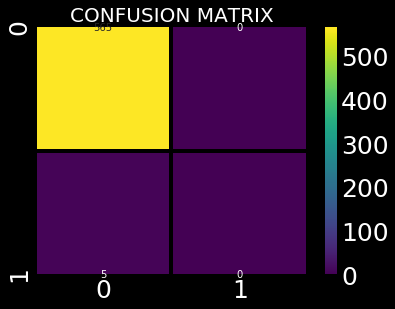

In [27]:
#K-NN classifier
from sklearn.neighbors import KNeighborsClassifier
underline = lambda text: '\033[4m' + text + '\033[0m'

knn = KNeighborsClassifier()
print(underline("KNeighbors Classifier\n"))
model(knn, x_train_res, y_train_res, x_test, y_test)

XGB Classifier

Accuracy mean----| 0.99822
Accuracy variance| 0.00218

Accuracy_score---| 0.99123

classification report |
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



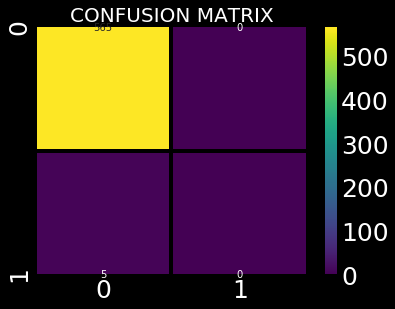

In [28]:
#XGB classifier
from xgboost import XGBClassifier
underline = lambda text: '\033[4m' + text + '\033[0m'

XGB_model = XGBClassifier()
print(underline("XGB Classifier\n"))
model(XGB_model, x_train_res, y_train_res, x_test, y_test)

SVM Model

Accuracy mean----| 1.0
Accuracy variance| 0.0

Accuracy_score---| 0.99123

classification report |
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



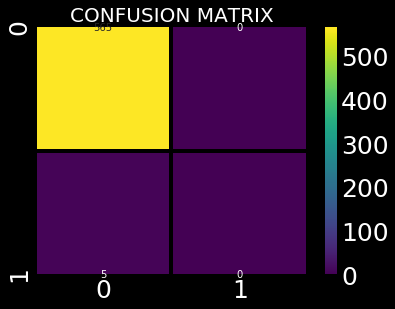

In [29]:
#SVM
from sklearn.svm import SVC
underline = lambda text: '\033[4m' + text + '\033[0m'

SVM_model=SVC(probability=True)
print(underline("SVM Model\n"))
model(SVM_model, x_train_res, y_train_res, x_test, y_test)

# Neural Networks using Keras

In [32]:
import tensorflow as tf
tf.random.set_seed(101)
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential # initialize neural network library
from keras.layers import Dense, Dropout # bulid layers library
underline = lambda text: '\033[4m' + text + '\033[0m]'

def build_classifier():
    classifier = Sequential() #initialize neural network
    classifier.add(Dense(units =4, kernel_initializer = 'uniform', activation = 'relu', input_dim = x_train_res.shape[1]))
    classifier.add(Dense(units =4, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units =1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer= 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn = build_classifier, epochs = 40)
accuracies = cross_val_score(estimator = classifier, X = x_train_res, y = y_train_res, cv =5, n_jobs=-1)
mean = accuracies.mean()
variance = accuracies.std()
print(underline("Keras Neural Network\n"))
print("Accuracy mean:\n "+ str(mean))
print("Accuracy variance: "+ str(variance))

Keras Neural Network
]
Accuracy mean:
 0.9172277331352234
Accuracy variance: 0.09200326351243834


## Repost Model w/ Random Forest and Incorporate Feature Importance

In [34]:
def model(classifier, dtrain_x, dtrain_y, dtest_x, dtest_y):
        
        #https://python-forum.io/Thread-Colored-text-output-in-python-3
        black = lambda text: '\033[0;30m' + text + '\033[0m'
        red = lambda text: '\033[0;31m' + text + '\033[0m'
        green = lambda text: '\033[0;32m' + text + '\033[0m'
        yellow = lambda text: '\033[0;33m' + text + '\033[0m'
        blue = lambda text: '\033[0;34m' + text + '\033[0m'
        magenta = lambda text: '\033[0;35m' + text + '\033[0m'
        cyan = lambda text: '\033[0;36m' + text + '\033[0m'
        white = lambda text: '\033[0;37m' + text + '\033[0m'
        bold = lambda test: '\033[1m' + text + '\033[0m'
        underline = lambda test: '\033[4m' + text + '\033[0m]'
        
        txt_clr = red
        txt_clr1=bold


        #fit the model
        classifier.fit(dtrain_x, dtrain_y)
        predictions = classifier.predict(dtest_x)
        
        #Cross validation
        accuracies = cross_val_score(estimator = classifier, X = x_train_res, y = y_train_res, cv = 5, n_jobs = -1)
        mean = accuracies.mean()
        variance = accuracies.std()
        print("Accuracy mean----| "+ str(   round(mean,5)     ))
        print("Accuracy variance| "+ str(   round(variance,5)   ))
    
        #Accuracy
        accuracy_sc = accuracy_score(dtest_y,predictions)
        print ("\nAccuracy_score---| "+ str( round(accuracy_sc,5) ))
    
        #Classification report
        print ("\nclassification report |\n",(classification_report(dtest_y,predictions)))
    
        #Confusion matrix
        plt.figure(figsize=(12,10))
        plt.subplot(221)
        sns.heatmap(confusion_matrix(dtest_y,predictions),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
        plt.title("CONFUSION MATRIX",fontsize=20)
        
        #Display feature importance   
        df1 = pd.DataFrame.from_records(dtrain_x)     
        tmp = pd.DataFrame({'Feature': df1.columns, 'Feature importance': classifier.feature_importances_})
        tmp = tmp.sort_values(by='Feature importance',ascending=False)
        plt.figure(figsize = (7,4))
        plt.title('Features importance',fontsize=14)
        s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
        plt.show()

Random Forest Classifier

Accuracy mean----| 1.0
Accuracy variance| 0.0

Accuracy_score---| 0.99123

classification report |
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



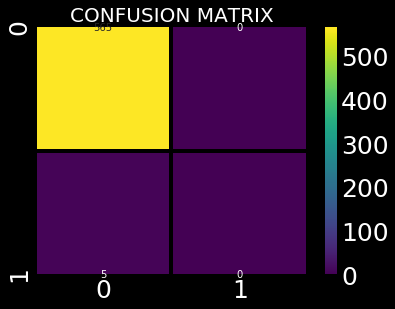

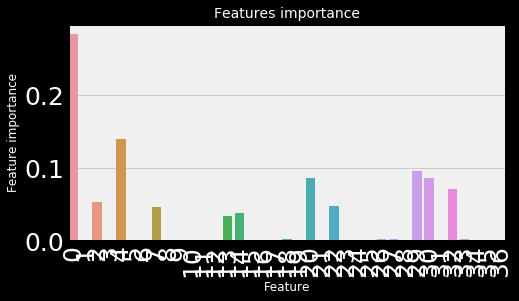

In [35]:
#Random forest
from sklearn.ensemble import RandomForestClassifier
underline = lambda text: '\033[4m' + text + '\033[0m'

rf_classifier = RandomForestClassifier()
print(underline("Random Forest Classifier\n"))
model(rf_classifier, x_train_res, y_train_res, x_test, y_test)